# Вебинар 3. Коллаборативная фильтрация

Исчерпывающую информацию с теорией, кодом и примерами можно найти в [статье](https://www.ethanrosenthal.com/2016/10/19/implicit-mf-part-1/)

# 1. Матричная факторизация

Раскладываем user-item матрицу на 2: матрицу латентных факторов юзеров и матрицу латентных факторов товаров

- латентый фактор = эмбеддинг (embedding)    

<img src='mf.png'>

(UхI) = (Uхk) * (kхI)

user = 1000

item = 3000

1000X3 3X3000

---

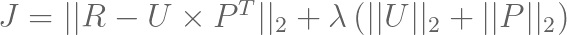

## Alternating Least Squares (ALS)

<img src="als_formula.png" >

$x_u^T$ - user embeddings  
$y_i$ - item embeddings  
$p_{ui}$ - 0/1. 1 - если в матрице user-item эдемент > 0 (было взаимодействие)  
$c_{ui}$ - Вес ошибки = элемент матрицы user-item  
$\lambda_x$, $\lambda_y$ - коэффициенты регуляризации  

**Алгоритм**  
ALS - лишь способ оптимизации (поиска коэффициентов в эмбеддингах):  

1. Фиксируем эмбеддинги юзеров $x_u^T$ --> легко посчитать производную по эмбеддингам товаров $y_i$
2. Обновляем эмбеддинги товаров (делаем шаг по антиградиенту = градиентный спуск)
3. Фиксируем эмбеддинги товаров $y_i$ --> легко посчитать производную по эмбеддингам юзеров $x_u^T$
4. Обновляем эмбеддинги юзеров (делаем шаг по антиградиенту = градиентный спуск)
5. Повторяем, пока процедура не сойдется

**Плюсы**
- Очень быстрый
- В продакшене можно зафиксировать на весь день эмбеддинги товаров (товары за день не меняются), 
    и в реал-тайм обновлять эмбеддинги юзеров при покупке
- Есть регуляризация $\lambda_x$, $\lambda_y$
- Есть веса ошибок $с_{u_i}$ - элементы матрицы user-item
- Библиотека implicit под капотом использует Cyton - очень быстро работает
- Predict для *всех* юзеров можно сделать просто перемножением 2-ух матриц - очень быстро
- Можно применять различные **взвешивания** матрицы: TF-IDF, BM25, ... . Это сильно улучшает качество

### 1. Базовое применение

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Для работы с матрицами
from scipy.sparse import csr_matrix

# Матричная факторизация
from implicit.als import AlternatingLeastSquares
from implicit.nearest_neighbours import bm25_weight, tfidf_weight

# Функции из 1-ого вебинара
import os, sys

module_path = os.path.abspath(os.path.join(os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from metrics import precision_at_k, recall_at_k

In [3]:
data = pd.read_csv('retail_train.csv')

data.columns = [col.lower() for col in data.columns]
data.rename(columns={'household_key': 'user_id',
                    'product_id': 'item_id'},
           inplace=True)


test_size_weeks = 3

data_train = data[data['week_no'] < data['week_no'].max() - test_size_weeks]
data_test = data[data['week_no'] >= data['week_no'].max() - test_size_weeks]

data_train.head(10)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.60,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.00,1631,1,0.0,0.0
2,2375,26984851472,1,1036325,1,0.99,364,-0.30,1631,1,0.0,0.0
3,2375,26984851472,1,1082185,1,1.21,364,0.00,1631,1,0.0,0.0
4,2375,26984851472,1,8160430,1,1.50,364,-0.39,1631,1,0.0,0.0
5,2375,26984851516,1,826249,2,1.98,364,-0.60,1642,1,0.0,0.0
6,2375,26984851516,1,1043142,1,1.57,364,-0.68,1642,1,0.0,0.0
7,2375,26984851516,1,1085983,1,2.99,364,-0.40,1642,1,0.0,0.0
8,2375,26984851516,1,1102651,1,1.89,364,0.00,1642,1,0.0,0.0
9,2375,26984851516,1,6423775,1,2.00,364,-0.79,1642,1,0.0,0.0


In [4]:
item_features = pd.read_csv('product.csv')
item_features.columns = [col.lower() for col in item_features.columns]
item_features.rename(columns={'product_id': 'item_id'}, inplace=True)

item_features.head(2)

,item_id,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product
0,25671,2,GROCERY,National,FRZN ICE,ICE - CRUSHED/CUBED,22 LB
1,26081,2,MISC. TRANS.,National,NO COMMODITY DESCRIPTION,NO SUBCOMMODITY DESCRIPTION,


In [5]:
item_features.department.unique()

array(['GROCERY', 'MISC. TRANS.', 'PASTRY', 'DRUG GM', 'MEAT-PCKGD',
       'SEAFOOD-PCKGD', 'PRODUCE', 'NUTRITION', 'DELI', 'COSMETICS',
       'MEAT', 'FLORAL', 'TRAVEL & LEISUR', 'SEAFOOD', 'MISC SALES TRAN',
       'SALAD BAR', 'KIOSK-GAS', 'ELECT &PLUMBING', 'GRO BAKERY',
       'GM MERCH EXP', 'FROZEN GROCERY', 'COUP/STR & MFG', 'SPIRITS',
       'GARDEN CENTER', 'TOYS', 'CHARITABLE CONT', 'RESTAURANT', 'RX',
       'PROD-WHS SALES', 'MEAT-WHSE', 'DAIRY DELI', 'CHEF SHOPPE', 'HBC',
       'DELI/SNACK BAR', 'PORK', 'AUTOMOTIVE', 'VIDEO RENTAL', ' ',
       'CNTRL/STORE SUP', 'HOUSEWARES', 'POSTAL CENTER', 'PHOTO', 'VIDEO',
       'PHARMACY SUPPLY'], dtype=object)

In [6]:
result = data_test.groupby('user_id')['item_id'].unique().reset_index()
result.columns=['user_id', 'actual']
result.head(2)

,user_id,actual
0,1,"[821867, 834484, 856942, 865456, 889248, 90795..."
1,3,"[835476, 851057, 872021, 878302, 879948, 90963..."


In [7]:
popularity = data_train.groupby('item_id')['quantity'].sum().reset_index()
popularity.rename(columns={'quantity': 'n_sold'}, inplace=True)

top_5000 = popularity.sort_values('n_sold', ascending=False).head(5000).item_id.tolist()

In [8]:
data_train.head(5)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.60,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.00,1631,1,0.0,0.0
2,2375,26984851472,1,1036325,1,0.99,364,-0.30,1631,1,0.0,0.0
3,2375,26984851472,1,1082185,1,1.21,364,0.00,1631,1,0.0,0.0
4,2375,26984851472,1,8160430,1,1.50,364,-0.39,1631,1,0.0,0.0


In [9]:
# Заведем фиктивный item_id

data_train.loc[~data_train['item_id'].isin(top_5000), 'item_id'] = 999999

user_item_matrix = pd.pivot_table(data_train, 
                                  index='user_id', columns='item_id', 
                                  values='quantity', # Можно пробовать другие варианты
                                  aggfunc='count', 
                                  fill_value=0
                                 )

user_item_matrix = user_item_matrix.astype(float) # необходимый тип матрицы для implicit

# переведем в формат saprse matrix
sparse_user_item = csr_matrix(user_item_matrix).tocsr()

user_item_matrix.head(3)

D:\Users\Pelmellika\anaconda3\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


item_id,202291,397896,420647,480014,545926,707683,731106,818980,819063,819227,...,15778533,15831255,15926712,15926775,15926844,15926886,15927403,15927661,15927850,16809471
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
user_item_matrix

item_id,202291,397896,420647,480014,545926,707683,731106,818980,819063,819227,...,15778533,15831255,15926712,15926775,15926844,15926886,15927403,15927661,15927850,16809471
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2496,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2497,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2498,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
userids = user_item_matrix.index.values
itemids = user_item_matrix.columns.values

matrix_userids = np.arange(len(userids))
matrix_itemids = np.arange(len(itemids))

id_to_itemid = dict(zip(matrix_itemids, itemids))
id_to_userid = dict(zip(matrix_userids, userids))

itemid_to_id = dict(zip(itemids, matrix_itemids))
userid_to_id = dict(zip(userids, matrix_userids))

In [12]:
userid_to_id[1984]

1983

# ALS

In [13]:
%%time

model = AlternatingLeastSquares(factors=100, 
                                regularization=0.001,
                                iterations=15, 
                                calculate_training_loss=True, 
                                num_threads=4)

model.fit(csr_matrix(user_item_matrix).T.tocsr(),  # На вход item-user matrix
          show_progress=True)

recs = model.recommend(userid=userid_to_id[2],  # userid - id от 0 до N
                        user_items=csr_matrix(user_item_matrix).tocsr(),   # на вход user-item matrix
                        N=5, # кол-во рекомендаций 
                        filter_already_liked_items=False, 
                        filter_items=None, 
                        recalculate_user=True)


Wall time: 7.74 s


In [14]:
[id_to_itemid[rec[0]] for rec in recs]

[1106523, 1133018, 999999, 5569230, 1082185]

In [15]:
def get_recommendations(user, model, N=5):
    res = [id_to_itemid[rec[0]] for rec in 
                    model.recommend(userid=userid_to_id[user], 
                                    user_items=sparse_user_item,   # на вход user-item matrix
                                    N=N, 
                                    filter_already_liked_items=False, 
                                    filter_items=None, 
                                    recalculate_user=True)]
    return res

In [16]:
%%time
    
result['als'] = result['user_id'].apply(lambda x: get_recommendations(x, model=model, N=5))
result.apply(lambda row: precision_at_k(row['als'], row['actual']), axis=1).mean()

Wall time: 1min 29s


0.16513222331047786

In [17]:
result.head(2)

,user_id,actual,als
0,1,"[821867, 834484, 856942, 865456, 889248, 90795...","[1033142, 5569374, 1005186, 1024306, 979707]"
1,3,"[835476, 851057, 872021, 878302, 879948, 90963...","[1133018, 1106523, 910032, 822407, 1022003]"


### Embeddings

In [18]:
model.item_factors.shape

(5001, 100)

In [19]:
pd.DataFrame(model.item_factors)

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,0.000491,0.002565,0.000496,0.003166,0.001912,0.001729,0.002203,0.003280,0.002087,0.003451,...,0.001061,0.002947,0.002347,0.002611,0.003789,0.001582,0.002800,0.001007,0.002237,0.001906
1,0.006542,0.003238,0.000041,0.006912,0.004540,0.001196,0.003651,0.008050,0.005526,0.006468,...,-0.000134,0.006052,0.003519,0.004832,0.005791,0.001247,0.001839,0.002161,0.007735,0.000847
2,0.002286,0.002325,-0.000817,0.003886,0.000983,0.001440,0.003813,0.002068,0.004235,0.004730,...,0.000969,0.001875,0.001817,0.001790,0.002191,0.002881,0.001148,0.000463,0.002284,0.000788
3,0.002256,0.003317,0.000295,0.004359,0.001462,0.000462,0.002459,0.006643,0.003007,0.004092,...,0.003350,0.002797,0.002373,0.001853,0.003932,0.002955,0.001711,0.001547,0.001895,0.002704
4,0.000625,0.002480,0.000658,0.003395,0.001882,0.001851,0.001937,0.002864,0.001609,0.003119,...,0.001372,0.002612,0.002152,0.001975,0.002891,0.001962,0.002857,0.001218,0.002077,0.002548
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4996,-0.003256,0.011682,0.002696,0.007488,0.001127,-0.002717,0.010537,0.009743,0.006069,0.011530,...,0.001620,0.007424,0.009928,0.013842,-0.002345,0.006999,0.005068,0.011291,0.001995,0.008794
4997,-0.001762,0.005376,0.000989,0.000249,0.002013,0.004370,0.000311,0.006013,0.003503,0.002559,...,0.009163,0.005091,0.001460,0.006207,0.013917,-0.000154,0.001468,0.002310,0.000571,0.002870
4998,-0.001139,0.002655,0.002938,0.003406,-0.001865,0.004568,0.006343,0.004867,0.005336,0.004143,...,0.004830,0.001056,0.001971,-0.000977,0.005807,0.008134,0.005265,-0.000819,0.001526,0.007339
4999,0.000222,0.004978,0.004566,0.002540,0.004600,0.005756,-0.001140,0.005786,0.003564,0.004251,...,0.003393,0.006586,0.007101,0.006748,0.009817,0.001962,0.005036,0.003262,0.002136,0.003413


In [20]:
model.user_factors.shape

(2499, 100)

In [21]:
pd.DataFrame(model.user_factors)

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,12.533318,0.281050,6.947406,-1.763400,-2.128716,3.831446,-1.201321,-1.893744,-0.181169,6.054410,...,1.135804,3.896221,5.394272,-4.055463,4.723475,2.001220,0.316686,-2.692487,-4.999817,5.937756
1,3.552746,1.670314,3.117848,-2.775759,4.995367,2.109510,-4.830534,-0.771017,0.188729,4.247021,...,4.104268,3.726420,3.012921,2.917902,4.214917,6.297536,-5.565514,2.350239,0.008209,1.064680
2,1.186494,2.589062,2.483264,-4.806982,5.439695,1.475907,4.390594,-0.568727,-2.788572,-3.914188,...,1.951826,6.251142,0.274499,1.840393,3.997544,5.705418,-8.075367,2.481050,-4.350789,1.841804
3,2.416940,3.234541,1.489915,0.083201,0.063310,-1.245840,-0.810997,-0.880694,-1.250093,4.527437,...,-0.070415,2.689102,0.437762,-1.191720,4.457641,1.324896,-3.110376,-1.657256,-2.188704,2.312640
4,2.825771,3.792385,2.717137,-3.657989,0.960987,-0.046022,-0.325789,0.417078,-3.557213,2.660130,...,0.489085,4.209881,0.196953,-0.001288,1.717840,2.939892,-1.411069,-0.740657,-0.460931,3.790267
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2494,5.039094,3.379466,3.674034,-4.036381,-2.123153,11.148289,-5.345170,2.921895,-1.474671,7.409273,...,3.365891,-0.991345,3.412273,-0.126422,1.473746,-1.835340,1.984730,-3.623282,0.484769,4.377414
2495,7.166578,-1.951895,1.747759,-4.301858,2.583551,0.343082,-2.968083,-3.006284,-1.244038,4.719306,...,-6.901146,-4.805286,5.616894,0.884260,4.332373,7.413620,-6.159646,0.985319,-1.720120,6.939039
2496,1.627235,1.172652,4.287278,-4.915984,-3.410077,-2.469779,-1.559964,-2.596953,-2.332079,2.888507,...,5.021236,3.852991,2.828418,1.396596,2.507611,1.591080,-1.070463,-2.260586,0.509469,3.743619
2497,3.532630,1.344005,1.387979,-0.307691,-1.718774,0.936078,0.209753,-2.688399,3.028986,2.677645,...,-0.800132,5.765162,-0.537972,3.659450,4.927104,3.366170,-6.420533,1.593810,1.732142,0.972153


Можно очень быстро посчитать предсказания, перемножив эти 2 матрицы

In [22]:
fast_recs = model.user_factors @ model.item_factors.T 
fast_recs.shape

(2499, 5001)

In [23]:
pd.DataFrame(fast_recs)

,0,1,2,3,4,5,6,7,8,9,...,4991,4992,4993,4994,4995,4996,4997,4998,4999,5000
0,0.004651,0.071570,-0.027717,-0.037941,0.014600,0.003751,0.022800,0.281613,0.038201,-0.029081,...,0.145538,0.092401,0.358667,0.146256,0.373060,0.098133,-0.035926,0.091943,0.072221,-0.059761
1,-0.004795,0.046799,-0.026035,0.000002,-0.007348,-0.009780,-0.017612,0.039241,0.061586,-0.014043,...,0.030711,0.006685,0.029074,0.064026,0.048139,0.028731,0.082528,-0.109411,0.069319,0.020840
2,-0.029375,-0.014126,0.011029,-0.051348,-0.020782,-0.012137,-0.027784,0.063237,0.023245,0.082193,...,0.003941,-0.073157,0.175241,0.193597,0.161033,0.221680,0.115487,-0.052190,0.088438,0.023843
3,0.006233,0.089320,0.044099,0.058791,0.011144,0.013531,0.001107,0.129368,0.051529,0.042849,...,0.040807,0.022837,-0.002037,-0.021462,0.034566,0.045303,0.050912,0.057501,0.018911,0.054744
4,-0.001769,0.044358,-0.004025,0.028780,0.003352,-0.000448,-0.002815,0.038180,0.025538,0.009408,...,-0.001441,-0.004894,0.009775,0.079591,0.057185,-0.034001,0.039253,-0.022396,0.020123,-0.023192
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2494,0.008711,-0.001800,0.043413,0.042772,0.006270,0.015664,-0.021864,0.096590,-0.143792,-0.104497,...,0.038191,-0.069605,0.093665,0.118997,0.164819,0.157093,0.126064,-0.017103,0.126315,0.091563
2495,0.019220,0.115578,0.053833,-0.043447,0.009340,0.013542,0.043964,0.100403,0.050972,0.263277,...,0.057497,0.310899,0.192715,0.177343,0.126454,0.175485,0.049102,0.015428,0.135329,0.071547
2496,0.052214,0.068518,-0.004140,0.020267,0.003333,-0.001297,0.007680,-0.142856,-0.000575,0.029476,...,0.020155,0.126520,0.050061,0.121075,0.226724,0.145791,0.051196,0.029750,0.040932,0.099006
2497,-0.013528,0.121268,0.025346,-0.026244,-0.016669,-0.008109,-0.005851,0.062824,0.364188,0.082592,...,0.006595,-0.055937,0.045867,-0.050784,0.080551,0.069767,0.145105,0.008987,0.000841,0.198955


In [24]:
import numpy as np
import pandas as pd
from matplotlib.pyplot import cm
import pickle

from scipy.spatial.distance import cdist

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import seaborn as sns


def reduce_dims(df, dims=2, method='pca'):
    
    assert method in ['pca', 'tsne'], 'Неверно указан метод'
    
    if method=='pca':
        pca = PCA(n_components=dims)
        components = pca.fit_transform(df)
    elif method == 'tsne':
        tsne = TSNE(n_components=dims, learning_rate=250, random_state=42)
        components = tsne.fit_transform(df)
    else:
        print('Error')
        
    colnames = ['component_' + str(i) for i in range(1, dims+1)]
    return pd.DataFrame(data = components, columns = colnames) 


def display_components_in_2D_space(components_df, labels='category', marker='D'):
    
    groups = components_df.groupby(labels)

    # Plot
    fig, ax = plt.subplots(figsize=(12,8))
    ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
    for name, group in groups:
        ax.plot(group.component_1, group.component_2, 
                marker='o', ms=6,
                linestyle='',
                alpha=0.7,
                label=name)
    ax.legend(loc='center left', bbox_to_anchor=(1.02, 0.5))

    plt.xlabel('component_1')
    plt.ylabel('component_2') 
    plt.show()

In [25]:
model.item_factors.shape

(5001, 100)

In [26]:
category = []

for idx in range(model.item_factors.shape[0]):

    try:
        cat = item_features.loc[item_features['item_id'] == id_to_itemid[idx], 'department'].values[0]
        category.append(cat)
    except:
        category.append('UNKNOWN')

In [27]:
print(category[:10])

['MISC SALES TRAN', 'KIOSK-GAS', 'MISC SALES TRAN', 'KIOSK-GAS', 'MISC SALES TRAN', 'MISC SALES TRAN', 'KIOSK-GAS', 'GROCERY', 'GROCERY', 'GROCERY']


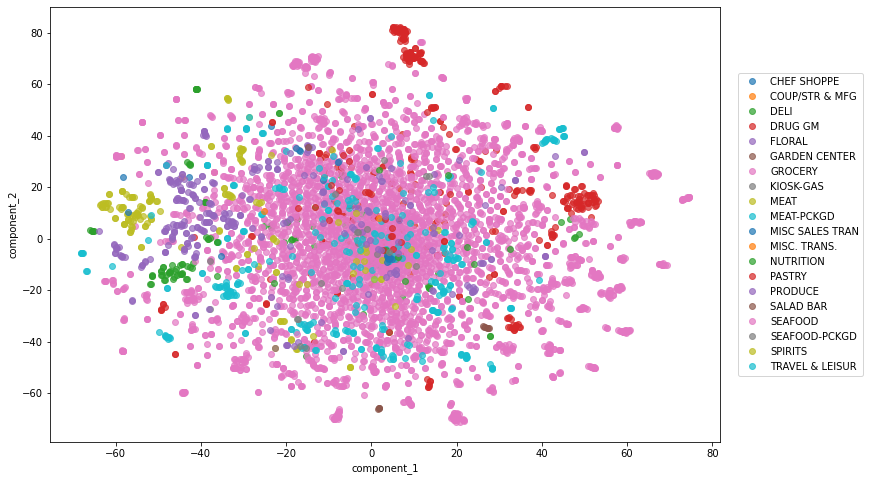

Wall time: 1min 45s


In [28]:
%%time
item_emb_tsne = reduce_dims(model.item_factors, dims=2, method='tsne') # 5001 х 100  ---> 5001 x 2
item_emb_tsne['category'] = category  # Добавляем категорию
item_emb_tsne = item_emb_tsne[item_emb_tsne['category'] != 'UNKNOWN']

display_components_in_2D_space(item_emb_tsne, labels='category')

Нарисуем все, кроме GROCERY

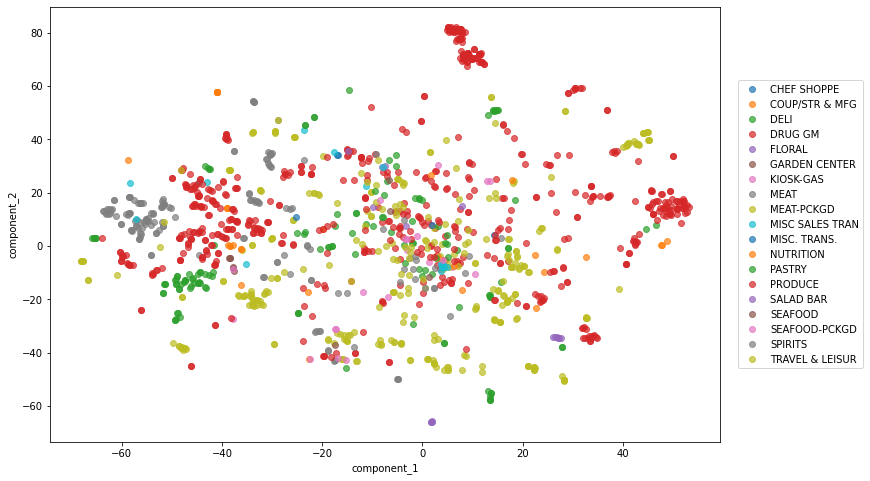

In [29]:
display_components_in_2D_space(item_emb_tsne[item_emb_tsne['category'] != 'GROCERY'], labels='category')

Нарисуем несколько конкретных категорий

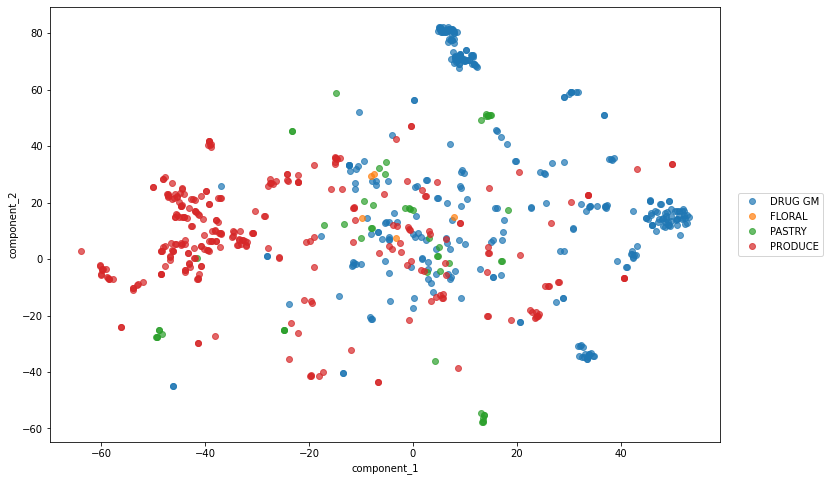

In [30]:
interesting_cats = ['PASTRY', 'PRODUCE', 'DRUG GM', 'FLORAL']

display_components_in_2D_space(item_emb_tsne[item_emb_tsne['category'].isin(interesting_cats)], 
                                             labels='category')

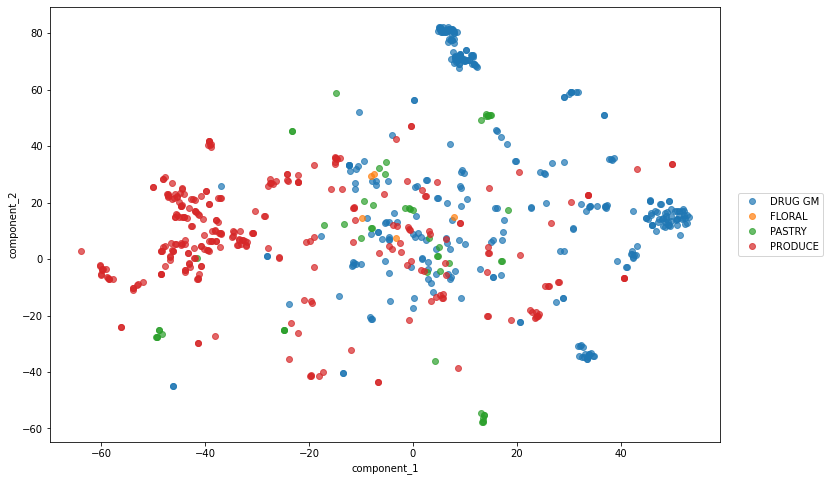

In [31]:
interesting_cats = ['PASTRY', 'PRODUCE', 'DRUG GM', 'FLORAL']

display_components_in_2D_space(item_emb_tsne[item_emb_tsne['category'].isin(interesting_cats)], 
                                             labels='category')

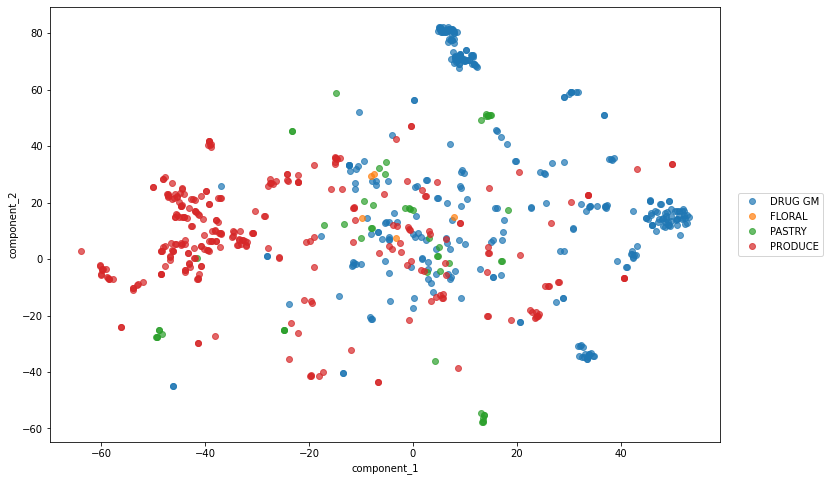

In [32]:
interesting_cats = ['PASTRY', 'PRODUCE', 'DRUG GM', 'FLORAL']

display_components_in_2D_space(item_emb_tsne[item_emb_tsne['category'].isin(interesting_cats)], 
                                             labels='category')

На самом деле, я бы сказал, что **результат средний**:
- Модель выучила похожесть только небольшой части товаров

In [33]:
item_emb_tsne.head(2)

,component_1,component_2,category
0,4.069465,-7.019206,MISC SALES TRAN
1,5.896340,-7.803860,KIOSK-GAS


recommend_all делает перемножение, но еще и сортирует и выбирает топ-N

In [34]:
%%time
recommendations = model.recommend_all(N=5, 
                                      user_items=csr_matrix(user_item_matrix).tocsr(),
                                      filter_already_liked_items=True, 
                                      filter_items=None, 
                                      recalculate_user=True,
                                      show_progress=True,
                                      batch_size=500)


Wall time: 56.4 s


In [35]:
recommendations.shape

(2499, 5)

In [36]:
pd.DataFrame(recommendations)

,0,1,2,3,4
0,2696,1927,832,3947,661
1,2148,2307,4346,2757,2927
2,3388,1659,558,1516,3029
3,3408,1801,3587,110,4346
4,3408,2148,3133,2307,4346
...,...,...,...,...,...
2494,1927,1923,2434,4287,1801
2495,2765,3301,647,70,1419
2496,4346,3587,2148,1349,4147
2497,300,4016,3704,2847,657


In [37]:
item_1 = model.item_factors[1]
item_2 = model.item_factors[2]

In [38]:
item_1.shape

(100,)

In [39]:
item_1

array([ 6.5419204e-03,  3.2380205e-03,  4.1044845e-05,  6.9124261e-03,
        4.5401696e-03,  1.1959476e-03,  3.6513701e-03,  8.0503160e-03,
        5.5261552e-03,  6.4678686e-03, -1.5373739e-04,  1.7035166e-03,
        2.2571282e-03,  4.2121178e-03,  4.5201909e-03,  2.0576690e-03,
        3.8773264e-03,  8.7188132e-04,  7.1294354e-03, -2.8857503e-03,
        6.1499709e-03, -6.3792206e-03,  3.1025356e-03, -1.3611153e-04,
        6.6956938e-03,  1.5594438e-03,  3.8769137e-04,  2.8248818e-03,
        4.6995445e-03,  1.9936666e-03,  1.8718881e-03,  6.9213565e-03,
       -2.6160274e-03,  4.4415067e-03,  2.4657650e-03,  7.9676532e-04,
        2.0910797e-03, -6.6308095e-04,  5.7760254e-03, -3.0464057e-03,
        1.0213401e-02, -2.2536331e-04,  3.4293025e-03,  2.1278148e-03,
        2.3025314e-03,  5.8265557e-03,  9.9048438e-04,  1.2439196e-03,
        4.2457948e-03,  4.1891318e-03,  3.2259044e-03,  2.9586902e-04,
        4.3757735e-03,  1.3489071e-03, -1.1185657e-03, -2.7270881e-03,
      

*Посмотрите также / Похожие товары*

In [40]:
example_item_row_id = 3606

In [41]:
closest_items = [ id_to_itemid[row_id] for row_id, score in model.similar_items(example_item_row_id, N=5)]

In [42]:
item_features[item_features.item_id.isin(closest_items)]

,item_id,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product
8143,839040,942,GROCERY,National,CONDIMENTS/SAUCES,HOT MUSTARD/SPECIALTY MUSTAR,12 OZ
14959,899459,69,GROCERY,Private,CHEESE,NATURAL CHEESE EXACT WT CHUNKS,1 LB
25270,990804,69,GROCERY,Private,VEGETABLES - SHELF STABLE,MUSHROOMS CND & GLASS,4.5 OZ
37579,1100265,69,GROCERY,Private,CHEESE,NATURAL CHEESE EXACT WT SLICES,10 OZ
41452,1135476,673,PRODUCE,National,BERRIES,STRAWBERRIES,1 LB


*Вашим друзьям нравится / Похожим пользователям нравится / ...*

Пользователь --> похожих пользовтелей --> рекомендовать те товары, которые купили похожие юзеры

In [43]:
model.similar_users(userid_to_id[10], N=5)

[(9, 0.9999999),
 (239, 0.976348),
 (1380, 0.97487676),
 (790, 0.9746884),
 (354, 0.9733661)]

### 2. TF-IDF взвешивание

In [44]:
user_item_matrix = tfidf_weight(user_item_matrix.T).T  # Применяется к item-user матрице ! 

In [45]:
%%time

model = AlternatingLeastSquares(factors=100, 
                                regularization=0.001,
                                iterations=15, 
                                calculate_training_loss=True, 
                                num_threads=4)

model.fit(csr_matrix(user_item_matrix).T.tocsr(),  # На вход item-user matrix
          show_progress=True)

result['als_tfidf'] = result['user_id'].apply(lambda x: get_recommendations(x, model=model, N=5))

result.apply(lambda row: precision_at_k(row['als_tfidf'], row['actual']), axis=1).mean()


Wall time: 1min 49s


0.1638589618021528

### 3. BM25 взвешивание

In [46]:
# Заведем фиктивный item_id (если юзер покупал товары из топ-5000, то он "купил" такой товар)
data_train.loc[~data_train['item_id'].isin(top_5000), 'item_id'] = 999999

user_item_matrix = pd.pivot_table(data_train, 
                                  index='user_id', columns='item_id', 
                                  values='quantity', # Можно пробовать другие варианты
                                  aggfunc='count', 
                                  fill_value=0
                                 )

user_item_matrix = user_item_matrix.astype(float) # необходимый тип матрицы для implicit

# переведем в формат saprse matrix
sparse_user_item = csr_matrix(user_item_matrix).tocsr()

user_item_matrix.head(3)

D:\Users\Pelmellika\anaconda3\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


item_id,202291,397896,420647,480014,545926,707683,731106,818980,819063,819227,...,15778533,15831255,15926712,15926775,15926844,15926886,15927403,15927661,15927850,16809471
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [47]:
user_item_matrix = bm25_weight(user_item_matrix.T).T  # Применяется к item-user матрице ! 

In [48]:
%%time

model = AlternatingLeastSquares(factors=100, 
                                regularization=0.001,
                                iterations=15, 
                                calculate_training_loss=True, 
                                num_threads=4) # K - кол-во билжайших соседей

model.fit(csr_matrix(user_item_matrix).T.tocsr(),  # На вход item-user matrix
          show_progress=True)

result['als_bm25'] = result['user_id'].apply(lambda x: get_recommendations(x, model=model, N=5))


Wall time: 2min 12s


In [49]:
result.apply(lambda row: precision_at_k(row['als_bm25'], row['actual']), axis=1).mean()

0.19255631733594228

In [50]:
result.to_csv('predictions_mf.csv', index=False)  # mf - matrix factorization

## 4. Важно искать оптимальные параметры

- regularization, iterations
- factors
- Вес (элемент в матрице user-item)

-----

# Production

Начиная с этого вебинара, мы будем строить *базовое решение* для системы рекомендаций топ-N товаров. В финальном проекте вам нужно будет его сущесвтенно улучшить.  
  
**Ситуация**: Вы работает data scientist в крупном продуктовом российском ритейлере. Ваш конкурент сделал рекомендательную систему, и его продажи выросли. Ваш менеджмент тоже хочет увеличить продажи   
**Задача со слов менеджера**: Сделайте рекомендательную систему топ-10 товаров для рассылки по e-mail

**Ожидание:**
- Отправляем e-mail с топ-10 товарами, отсортированными по вероятности

**Реальность:**
- Чего хочет менеджер от рекомендательной системы? (рост показателя X на Y% за Z недель)
- По-хорошему надо бы предварительно посчитать потенциальный эффект от рекоммендательной системы (Оценки эффектов у менеджера и у вас могут сильно не совпадать: как правило, вы знаете про данные больше)
- А у нас вообще есть e-mail-ы пользователей? Для скольки %? Не устарели ли они?
- Будем ли использовать СМС и push-уведомления в приложении? Может, будем печатать рекомендации на чеке после оплаты на кассе?
- Как будет выглядеть e-mail? (решаем задачу топ-10 рекомендаций или ранжирования? И топ-10 ли?)
- Какие товары должны быть в e-mail? Есть ли какие-то ограничения (только акции и т п)?
- Сколько денег мы готовы потратить на привлечение 1 юзера? CAC - Customer Aquisition Cost. Обычно CAC = расходы на коммуникацию + расходы на скидки
- Cколько мы хотим зарабатывать с одного привлеченного юзера?
---
- А точно нужно сортировать по вероятности?
- Какую метрику использовать?
- Сколько раз в неделю отпрпавляем рассылку?
- В какое время отправляем рассылку?
- Будем отправлять одному юзеру много раз наши рекоммендации. Как добиться того, чтобы они хоть немного отличались?
- Нужно ли, чтобы в одной рассылке были *разные* товары? Как определить, что товары *разные*? Как добиться того, чтобы они были разными?
- И многое другое:)

**В итоге договорились, что:**
- Хотим повысить выручку минимум на 6% за 4 месяца. Будем повышать за счет роста Retention минимум на  3% и среднего чека минимум на 3%
- Топ-5 товаров, а не топ-10 (В e-mail 10 выглядят не красиво, в push и на чек больше 5 не влезает)
- Рассылаем в e-mail (5% клиентов) и push-уведомлении (20% клиентов), печатаем на чеке (все оффлайн клиенты)
- **3 товара с акцией** (Как это учесть? А если на товар была акция 10%, а потом 50%, что будет стоять в user-item матрице?)
- **1 новый товар** (юзер никогда не покупал. Просто фильтруем аутпут ALS? А если у таких товаров очень маленькая вероятность покупки? Может, использовать другую логику/модель?) 
- **1 товар для роста среднего чека** (товары минимум дороже чем обычно покупает юзер. Как это измерить? На сколько дороже?)

Вопросов стало еще больше. Поэтому сначала делаем **MVP** (Minimum viable product) на e-mail. Показываем его менеджеру, измеряем метрики на юзерах. По фидбеку и метрикам делаем улучшения MVP и раскатываем его на push-уведомления и чеки

*Data Science проект* - итеративный процесс!

In [51]:
data_train.head(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.6,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.0,1631,1,0.0,0.0


In [52]:
data_train['price'] = data_train['sales_value'] / (np.maximum(data_train['quantity'], 1))
data_train['price'].max()

<ipython-input-52-73e31537f690>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_train['price'] = data_train['sales_value'] / (np.maximum(data_train['quantity'], 1))


499.99

In [53]:
# < 1$
data_train['price'].quantile(0.20)

0.99

In [54]:
# > 100$
data_train['price'].quantile(0.99995)

82.01435450003483

In [83]:
def prefilter_items(data):
    # Уберем самые популярные товары (их и так купят)
    popularity = data_train.groupby('item_id')['user_id'].nunique().reset_index() / data_train['user_id'].nunique()
    popularity.rename(columns={'user_id': 'share_unique_users'}, inplace=True)
    
    top_popular = popularity[popularity['share_unique_users'] > 0.5].item_id.tolist()
    data = data[~data['item_id'].isin(top_popular)]
    
    # Уберем самые НЕ популярные товары (их и так НЕ купят)
    top_notpopular = popularity[popularity['share_unique_users'] < 0.01].item_id.tolist()
    data = data[~data['item_id'].isin(top_notpopular)]
    
    # Уберем товары, которые не продавались за последние 12 месяцев
    data = data[data['week_no'] < 52]
    
    # Уберем не интересные для рекоммендаций категории (department)
    item_not_interesting = item_features[item_features['department'].isin(['PHOTO', 'VIDEO', 'COUP/STR & MFG', 'RX'])].item_id.tolist()
    data = data[~data['item_id'].isin(item_not_interesting)]
    
    # Уберем слишком дешевые товары (на них не заработаем). 1 покупка из рассылок стоит 60 руб. 
    data = data[data['sales_value'] > 1]
    
    # Уберем слишком дорогие товары
    data = data[data['sales_value'] < 100]
    
def postfilter_items(user_id, recommednations):
    pass

Все эти функции отправим затем в *utils.py*

In [85]:
from sklearn.model_selection import GridSearchCV

In [ ]:
%%time

model = AlternatingLeastSquares(factors=100, 
                                regularization=0.001,
                                iterations=15, 
                                calculate_training_loss=True, 
                                num_threads=4)

model.fit(csr_matrix(user_item_matrix).T.tocsr(),  # На вход item-user matrix
          show_progress=True)

recs = model.recommend(userid=userid_to_id[2],  # userid - id от 0 до N
                        user_items=csr_matrix(user_item_matrix).tocsr(),   # на вход user-item matrix
                        N=5, # кол-во рекомендаций 
                        filter_already_liked_items=False, 
                        filter_items=None, 
                        recalculate_user=True)

In [89]:
parameters = {'factors':[10, 100, 1000], 'regularization': [0, 0.01, 0.001, 0.0001], 'iterations': [10, 50, 100]}
GridSearchCV(AlternatingLeastSquares(), parameters)

GridSearchCV(estimator=<implicit.als.AlternatingLeastSquares object at 0x000002002E362C10>,
             param_grid={'factors': [10, 100, 1000],
                         'iterations': [10, 50, 100],
                         'regularization': [0, 0.01, 0.001, 0.0001]})

# ДЗ

1) Попытаться ответить на вопросы/выдвинуть гипотезы

2) Доделать прошлые домашния задания

3) Прочитать статьи BM25/MatrixFactorization

4) Поэкспериментировать с ALS (grid-search)

# Links

BM25

https://en.wikipedia.org/wiki/Okapi_BM25#:~:text=BM25%20is%20a%20bag%2Dof,slightly%20different%20components%20and%20parameters.


Matrix factorization (ALS, SVD)
https://datasciencemadesimpler.wordpress.com/tag/alternating-least-squares/